# Hospital ward dynamic contact network
Lien vers l'article: http://www.sociopatterns.org/datasets/hospital-ward-dynamic-contact-network/

Le notebook est divisé en plusieurs parties afin d’analyser de manière structurée les graphes de contacts hospitaliers et de couvrir les principaux concepts.

1. Contexte des données
2. Représentation des graphes
3. Propriétés statistiques des réseaux (analyse descriptive)
4. Centralités
5. Communautés et modularité
6. Graphes pondérés et temporels
7. Random walks, diffusion
8. Modèles de graphes

Le choix des concepts est justifié et discuté dans le rapport écrit.

In [26]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import community as community_louvain
from collections import Counter

plt.rcParams["figure.figsize"] = (6,4)

ROLE_COLORS = {
    "MED": "#7B2CBF",  # violet
    "NUR": "#F4A261",  # sable/orangé doux
    "ADM": "#2A9D8F",  # teal
    "PAT": "#264653",  # bleu pétrole
}
UNKNOWN_COLOR = "#BDBDBD"

def role_color(G, n):
    return ROLE_COLORS.get(G.nodes[n].get("role",""), UNKNOWN_COLOR)

legend_handles = [mpatches.Patch(color=c, label=r) for r, c in ROLE_COLORS.items()]


## 1. Contexte des données

In [27]:
df = pd.read_csv("./data/detailed_list_of_contacts_Hospital.dat", sep=r"\s+", header=None)
df.columns = ["t", "id_1", "id_2", "role_1", "role_2"]

# Dictionnaire id => role
roles_1 = df[["id_1", "role_1"]].rename(columns={"id_1":"id","role_1":"role"})
roles_2 = df[["id_2", "role_2"]].rename(columns={"id_2":"id","role_2":"role"})
roles = pd.concat([roles_1, roles_2]).drop_duplicates()
role_dict = dict(zip(roles["id"], roles["role"]))

# Paires non orientées
df["u"] = df[["id_1","id_2"]].min(axis=1)
df["v"] = df[["id_1","id_2"]].max(axis=1)

# Tri pour épisodes
df = df.sort_values(["u","v","t"])

# Episodes de contact (pas de 20s)
df["new_contact"] = (df["t"] != df.groupby(["u","v"])["t"].shift() + 1)
df["contact_id"] = df.groupby(["u","v"])["new_contact"].cumsum()

contacts = (
    df.groupby(["u", "v", "contact_id"])
      .agg(start_t=("t","min"), end_t=("t","max"), n_intervals=("t","count"))
      .reset_index()
)
contacts["duration_seconds"] = contacts["n_intervals"] * 20

## 2. Représentation des graphes
Agrégation temporelle des données pour obtenir un graphe statique qui résume l’ensemble des interactions observées

Nb de noeuds: 75
Nb d'arêtes: 1139


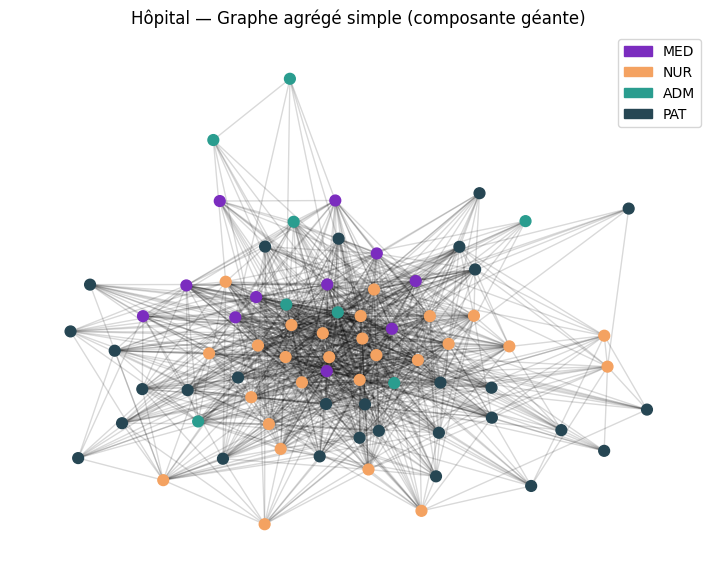

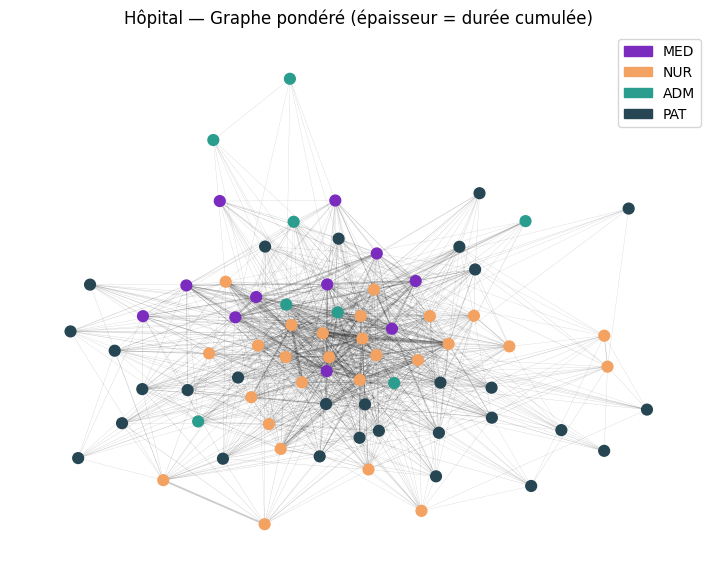

In [28]:
edges_unique = df[["u","v"]].drop_duplicates()

# Graphe non pondéré agrégé
G = nx.Graph()
G.add_edges_from(edges_unique.itertuples(index=False, name=None))
nx.set_node_attributes(G, role_dict, name="role")

print("Nb de noeuds:", G.number_of_nodes())
print("Nb d'arêtes:", G.number_of_edges())

# Graphe pondéré par durée cumulée (somme des intervalles*20)
edge_duration = (
    df.groupby(["u","v"])
      .size()
      .reset_index(name="n_intervals")
)
edge_duration["cumulativeduration"] = edge_duration["n_intervals"] * 20

G_w = nx.Graph()
for _, r in edge_duration.iterrows():
    G_w.add_edge(r["u"], r["v"], weight=r["cumulativeduration"])
nx.set_node_attributes(G_w, role_dict, name="role")

def giant_component_subgraph(H):
    comp = max(nx.connected_components(H), key=len)
    return H.subgraph(comp).copy()

Gs = giant_component_subgraph(G)
Gw = giant_component_subgraph(G_w)

pos = nx.spring_layout(Gs, seed=42, k=0.3)

# --- Plot graphe simple ---
plt.figure(figsize=(9, 7))
plt.legend(handles=legend_handles, loc="best")
nx.draw_networkx_edges(Gs, pos, alpha=0.15)
nx.draw_networkx_nodes(
    Gs, pos,
    node_color=[role_color(Gs, n) for n in Gs.nodes()],
    node_size=60
)
plt.title("Hôpital — Graphe agrégé simple (composante géante)")
plt.axis("off")
plt.show()

# --- Plot graphe pondéré (durée cumulée) ---
edges = list(Gw.edges())
w = np.array([Gw[u][v]["weight"] for u, v in edges], dtype=float)
if len(w) and w.max() > 0:
    edge_widths = 0.2 + 4.0 * (w / w.max())
else:
    edge_widths = 0.2

plt.figure(figsize=(9, 7))
plt.legend(handles=legend_handles, loc="best")
nx.draw_networkx_edges(Gw, pos, alpha=0.20, width=edge_widths)
nx.draw_networkx_nodes(
    Gw, pos,
    node_color=[role_color(Gw, n) for n in Gw.nodes()],
    node_size=60
)
plt.title("Hôpital — Graphe pondéré (épaisseur = durée cumulée)")
plt.axis("off")
plt.show()

## 3. Propriétés statistiques des réseaux (analyse descriptive)

N (noeuds) = 75
M (arêtes) = 1139
Densité = 0.4104504504504505
Nombre de composantes connexes = 1
Taille de la composante géante = 75 (100.0% des noeuds)
Degré moyen = 30.373333333333335
Degré médian = 27.0
Degré max = 61


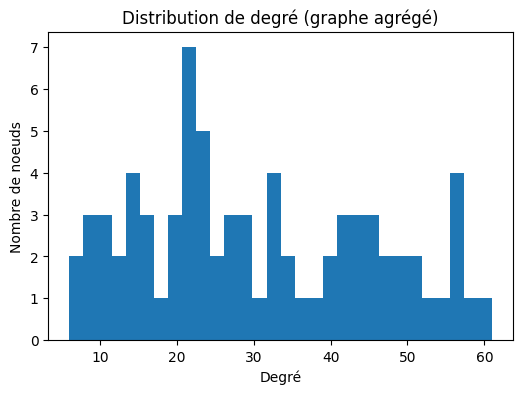

Clustering moyen (moyenne locale) = 0.6402796539914468
Transitivity (clustering global) = 0.5880037219955623


In [29]:
N, M = G.number_of_nodes(), G.number_of_edges()
print("N (noeuds) =", N)
print("M (arêtes) =", M)
print("Densité =", nx.density(G))

components = list(nx.connected_components(G))
gcc_size = len(max(components, key=len))
print("Nombre de composantes connexes =", len(components))
print("Taille de la composante géante =", gcc_size, f"({gcc_size/N:.1%} des noeuds)")

degrees = np.array([d for _, d in G.degree()])
print("Degré moyen =", degrees.mean())
print("Degré médian =", np.median(degrees))
print("Degré max =", degrees.max())

plt.figure()
plt.hist(degrees, bins=30)
plt.xlabel("Degré")
plt.ylabel("Nombre de noeuds")
plt.title("Distribution de degré (graphe agrégé)")
plt.show()

clustering_local = nx.clustering(G)
print("Clustering moyen (moyenne locale) =", np.mean(list(clustering_local.values())))
print("Transitivity (clustering global) =", nx.transitivity(G))


## 4. Centralités

In [30]:
degree_centrality = dict(G.degree())
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top degree:", top_degree)

betweenness = nx.betweenness_centrality(G, normalized=True)
top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top betweenness:", top_betweenness)

closeness = nx.closeness_centrality(G)
top_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top closeness:", top_closeness)

Top degree: [(1098, 61), (1193, 58), (1115, 57), (1164, 57), (1210, 56), (1295, 56), (1109, 55), (1157, 53), (1658, 51), (1144, 50)]
Top betweenness: [(1098, 0.040408304449621735), (1193, 0.035156420279650484), (1164, 0.03126633321619273), (1115, 0.02868887767458861), (1109, 0.027834568483203603), (1295, 0.026827641756601073), (1210, 0.026449931825272565), (1658, 0.0226571084756681), (1190, 0.02216525800306036), (1157, 0.021651503844714686)]
Top closeness: [(1098, 0.8505747126436781), (1193, 0.8222222222222222), (1115, 0.8131868131868132), (1164, 0.8131868131868132), (1210, 0.8043478260869565), (1295, 0.8043478260869565), (1109, 0.7956989247311828), (1157, 0.7789473684210526), (1658, 0.7628865979381443), (1144, 0.7551020408163265)]


## 5. Communautés et modularité

Nombre de communautés détectées : 5
Taille des communautés: Counter({3: 22, 0: 18, 2: 13, 1: 13, 4: 9})
role       ADM  MED  NUR  PAT
community                    
0            4   10    0    4
1            0    0    7    6
2            2    0    6    5
3            0    1   10   11
4            2    0    4    3


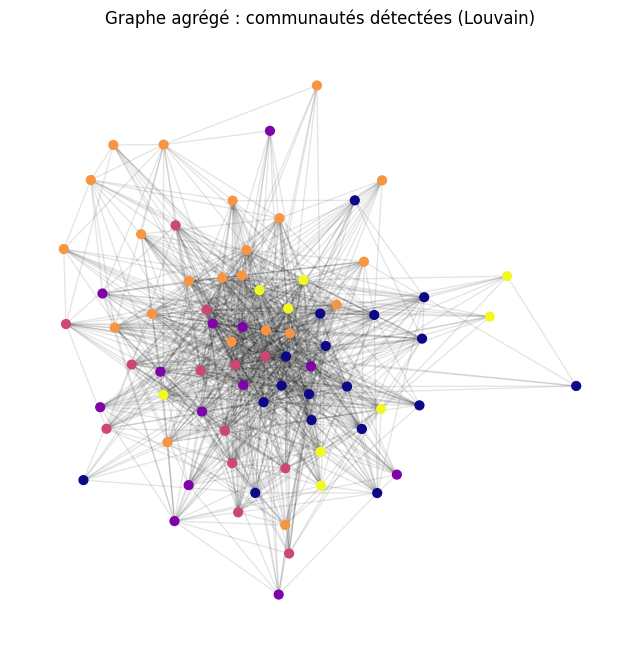

In [31]:
partition = community_louvain.best_partition(G)
nx.set_node_attributes(G, partition, name="community")
print("Nombre de communautés détectées :", len(set(partition.values())))
print("Taille des communautés:", Counter(partition.values()))

df_comm = pd.DataFrame([(n, G.nodes[n]["role"], G.nodes[n]["community"]) for n in G.nodes()],
                       columns=["id", "role", "community"])
print(pd.crosstab(df_comm["community"], df_comm["role"]))

pos2 = nx.spring_layout(G, seed=42)
node_colors = [partition[n] for n in G.nodes()]
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos2, node_color=node_colors, node_size=40, cmap=plt.cm.plasma)
nx.draw_networkx_edges(G, pos2, alpha=0.1)
plt.title("Graphe agrégé : communautés détectées (Louvain)")
plt.axis("off")
plt.show()

## 6. Graphes pondérés et temporels

In [32]:
edge_episodes = (
    contacts.groupby(["u","v"])
    .agg(
        Ncontacts=("contact_id", "nunique"),
        cumulativeduration=("duration_seconds", "sum")
    )
    .reset_index()
)

# (A) Pondéré par durée cumulée
G_duration = nx.Graph()
for _, row in edge_episodes.iterrows():
    G_duration.add_edge(row["u"], row["v"], weight=row["cumulativeduration"])
nx.set_node_attributes(G_duration, role_dict, name="role")

partition_duration = community_louvain.best_partition(G_duration, weight="weight")
modularity_duration = community_louvain.modularity(partition_duration, G_duration, weight="weight")
print(f"Modularité (pondérée par durée) : {modularity_duration:.4f}")

# (B) Pondéré par nombre d’épisodes (Ncontacts)
G_weighted = nx.Graph()
for _, row in edge_episodes.iterrows():
    G_weighted.add_edge(row["u"], row["v"], weight=row["Ncontacts"])
nx.set_node_attributes(G_weighted, role_dict, name="role")

partition_ncontacts = community_louvain.best_partition(G_weighted, weight="weight")
modularity_ncontacts = community_louvain.modularity(partition_ncontacts, G_weighted, weight="weight")
print(f"Modularité (pondérée par Ncontacts) : {modularity_ncontacts:.4f}")


Modularité (pondérée par durée) : 0.3677
Modularité (pondérée par Ncontacts) : 0.3677
